In [714]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Data Cleaning

In [715]:
all_complaints = pd.read_csv('data/DOB_Complaints_Received.csv')
print(list(all_complaints))
print(len(all_complaints))

/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (4,7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['Complaint Number', 'Status', 'Date Entered', 'House Number', 'ZIP Code', 'House Street', 'BIN', 'Community Board', 'Special District', 'Complaint Category', 'Unit', 'Disposition Date', 'Disposition Code', 'Inspection Date', 'DOBRunDate']
2299448


### Handle types

In [716]:
all_complaints['Complaint Category'] = all_complaints['Complaint Category'].astype(str)

### Filter down to just Boilers
56 | Boiler – Fumes/Smoke/Carbon Monoxide | A 

58 | Boiler – Defective/Non-operative/No Permit | B

82 | Boiler – Accident/Explosion | A

**We chose to only focus on complaint category 58 because it accounts for a vast majority of boiler complaints**

In [717]:
complaint_categories = ['58', '56', '82']
# complaint_categories = ['58']

boiler_complaints = all_complaints[all_complaints['Complaint Category'].isin(complaint_categories)]

print("Number of total complaints: {}\n".format(len(all_complaints)))

print("Boiler complaint count by category:\n{}\n".format(boiler_complaints['Complaint Category'].value_counts()))

boiler_complaints = boiler_complaints[boiler_complaints['Complaint Category'] == '58']

print("Number of boiler complaints: {}".format(len(boiler_complaints)))

Number of total complaints: 2299448

Boiler complaint count by category:
58    29745
56     2529
82       36
Name: Complaint Category, dtype: int64

Number of boiler complaints: 29745


### Inspections over time

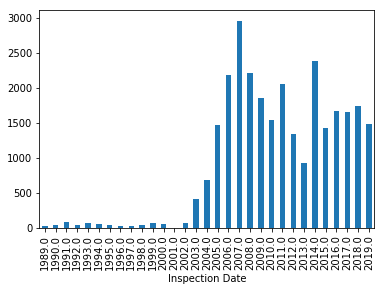

In [718]:
boiler_complaints['Inspection Date'] = pd.to_datetime(boiler_complaints['Inspection Date'])
boiler_complaints.groupby(boiler_complaints['Inspection Date'].dt.year).count()['BIN'].plot(kind='bar')

### Remove duplicate complaints

In [719]:
boiler_complaints = boiler_complaints.drop_duplicates(subset=['BIN', 'Date Entered'])
print("number of boiler complaints after dropping duplicates: {}".format(len(boiler_complaints)))

number of boiler complaints after dropping duplicates: 27690


### Filter down to relevant labels

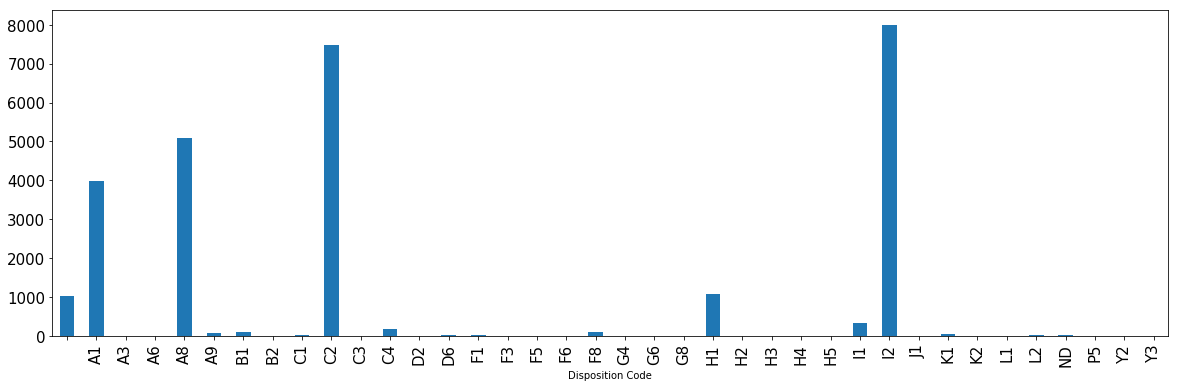

In [720]:
# print(boiler_complaints['Disposition Code'].value_counts())
boiler_complaints.groupby('Disposition Code').count()['BIN'].plot('bar', figsize=(20, 6), fontsize=15)

**Positive**: A8 (ECB Violation Served), A1 (Buildings Violation(s) Served), B1 (Buildings Violation(s) Prepared and Attempt to Serve will be Made)

**Negative**: I2 (No Violation Warranted for Complaint at Time of Inspection), I1 (Complaint Unsubstantiated Based on Department Records), 

**Note**: C2 (Inspector Unable to Gain Access – Final Attempt) did not include to assume we could gain access to the building.  It kind of seems like that would be a different classification task

In [721]:
positive_labels = ['A1', 'A8', 'B1']
negative_labels = ['I1', 'I2']
boiler_complaints = boiler_complaints[boiler_complaints['Disposition Code'].isin(positive_labels + negative_labels)]
print("Number of complaints after filter down to relevant dispoisition codes: {}".format(len(boiler_complaints)))

Number of complaints after filter down to relevant dispoisition codes: 17511


# Create Labels

In [722]:
labels = boiler_complaints['Disposition Code'].isin(positive_labels) * 1

In [723]:
print("Percent of labels that are positive (result in violation): {}".format(sum(labels) / len(labels)))

Percent of labels that are positive (result in violation): 0.5244703329335846


# Create Features

In [724]:
boiler_complaints['Violation'] = labels

In [725]:
def violation_ratio_test(column):
    """ Will calculate the ratio of violation to complaints for each category of a given column."""
    return boiler_complaints.groupby(column)['Violation'].sum() / boiler_complaints.groupby(column).count()['Violation']

### Boiler Category / Priority
This is useful if predicting for multiple complaint categories

In [726]:
boiler_complaints['Complaint Category'] = boiler_complaints['Complaint Category'].astype('category')
boiler_complaints['Complaint Category'] = boiler_complaints['Complaint Category'].cat.codes

In [727]:
violation_ratio_test('Complaint Category')

Complaint Category
0    0.52447
Name: Violation, dtype: float64

### Number of previous boiler complaints

In [728]:
def get_previous_complaints(row):
    """ Returns the number of previous complaints for a given bin."""
    bin_complaints = boiler_complaints[boiler_complaints['BIN'] == row['BIN']]
    bin_complaints = bin_complaints[boiler_complaints['Complaint Number'] != row['Complaint Number']]
    return len(bin_complaints)

In [729]:
boiler_complaints['Previous Complaints'] = boiler_complaints.apply(get_previous_complaints, axis=1 )

/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [730]:
boiler_complaints['Previous Complaints'].value_counts()

0     9114
1     3262
2     1635
3      836
4      505
5      312
6      308
7      200
9      170
8      135
10     132
13      98
40      82
14      75
73      74
22      69
66      67
12      65
11      60
51      52
16      51
19      40
36      37
17      36
26      27
25      26
21      22
20      21
Name: Previous Complaints, dtype: int64

In [731]:
violation_ratio_test('Previous Complaints').sort_values(ascending=False)

Previous Complaints
21    0.636364
2     0.560245
0     0.543120
6     0.542208
1     0.531576
3     0.531100
12    0.523077
8     0.503704
5     0.500000
4     0.499010
22    0.492754
9     0.441176
14    0.440000
10    0.416667
19    0.400000
25    0.346154
7     0.340000
51    0.326923
11    0.300000
26    0.296296
13    0.285714
66    0.283582
40    0.256098
16    0.254902
73    0.243243
17    0.222222
36    0.216216
20    0.047619
Name: Violation, dtype: float64

In [732]:
# Checking to make sure these aren't duplicate 
boiler_complaints[boiler_complaints['BIN'] == 1015102]

,Complaint Number,Status,Date Entered,House Number,ZIP Code,House Street,BIN,Community Board,Special District,Complaint Category,Unit,Disposition Date,Disposition Code,Inspection Date,DOBRunDate,Violation,Previous Complaints
127622,1134056,CLOSED,12/19/2004,139,10001,WEST 28 STREET,1015102,105,,0,BOILR,01/24/2005,I2,2005-01-18,11/07/2018 12:00:00 AM,0,1
181203,1190768,CLOSED,04/10/2007,139,10001,WEST 28 STREET,1015102,105,,0,BOILR,05/04/2007,A1,2007-04-27,11/07/2018 12:00:00 AM,1,1


### Number of previous boiler violations

In [733]:
def get_previous_violations(row):
    """ Returns the number of previous complaints for a given bin."""
    bin_complaints = boiler_complaints[boiler_complaints['BIN'] == row['BIN']]
    bin_complaints = bin_complaints[bin_complaints['Violation'] == 1]
    bin_complaints = bin_complaints[boiler_complaints['Complaint Number'] != row['Complaint Number']]
    return len(bin_complaints)

In [734]:
boiler_complaints['Previous Violations'] = boiler_complaints.apply(get_previous_violations, axis=1 )

/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [735]:
boiler_complaints['Previous Violations'].value_counts()

0     11401
1      2899
2      1282
3       644
4       342
5       231
6       151
8       120
18       98
7        95
17       71
19       48
9        47
13       28
21       22
16       17
14       14
22        1
Name: Previous Violations, dtype: int64

In [736]:
violation_ratio_test('Previous Violations').sort_values(ascending=False)

Previous Violations
21    1.000000
16    1.000000
13    1.000000
2     0.641186
4     0.599415
5     0.597403
1     0.542256
8     0.525000
0     0.511709
17    0.507042
3     0.478261
6     0.463576
7     0.421053
9     0.212766
18    0.193878
14    0.000000
19    0.000000
22    0.000000
Name: Violation, dtype: float64

### Number of previous boiler violations / complaints ratio

In [737]:
boiler_complaints['Violation Ratio'] = (boiler_complaints['Previous Violations'] / boiler_complaints['Previous Complaints']).fillna(0)
boiler_complaints.head()

,Complaint Number,Status,Date Entered,House Number,ZIP Code,House Street,BIN,Community Board,Special District,Complaint Category,Unit,Disposition Date,Disposition Code,Inspection Date,DOBRunDate,Violation,Previous Complaints,Previous Violations,Violation Ratio
2082,1002230,CLOSED,06/08/1989,2647,10025,BROADWAY,1056486,107,,0,BOILR,09/18/1989,B1,1989-05-15,11/07/2018 12:00:00 AM,1,0,0,0.000000
2083,1002231,CLOSED,06/08/1989,550,10033,WEST 184TH ST,1063680,112,,0,BOILR,09/18/1989,I2,1989-05-16,11/07/2018 12:00:00 AM,0,3,2,0.666667
2084,1002232,CLOSED,06/08/1989,245,10009,EAST 2ND ST,1004584,103,,0,BOILR,01/09/1990,A1,1989-11-14,11/07/2018 12:00:00 AM,1,0,0,0.000000
2094,1002242,CLOSED,06/08/1989,224,10128,EAST 89 STREET,1085225,108,,0,BOILR,11/17/1989,I2,1989-10-31,11/07/2018 12:00:00 AM,0,0,0,0.000000
2883,1003104,CLOSED,08/11/1989,640,10031,RIVERSIDE DRIVE,1062326,109,,0,BOILR,01/04/1990,I2,1989-11-30,11/07/2018 12:00:00 AM,0,1,1,1.000000


In [738]:
print(boiler_complaints['Violation Ratio'].value_counts())
violation_ratio_test('Violation Ratio')

0.000000    11401
1.000000     2677
0.500000      920
0.666667      416
0.333333      282
0.250000      156
0.750000      135
0.200000       90
0.600000       88
0.428571       72
0.285714       62
0.800000       61
0.400000       59
0.246575       56
0.222222       51
0.272727       48
0.287879       48
0.142857       47
0.833333       44
0.075000       38
0.375000       33
0.076923       28
0.444444       27
0.125000       27
0.571429       26
0.307692       24
0.050000       23
0.450000       23
0.625000       22
0.954545       22
            ...  
0.888889       11
0.181818       11
0.230769       11
0.777778       11
0.437500       10
0.714286        9
0.857143        9
0.615385        9
0.384615        9
0.320000        9
0.700000        8
0.363636        8
0.636364        8
0.269231        8
0.194444        8
0.461538        7
0.538462        7
0.642857        6
0.736842        6
0.416667        6
0.294118        6
0.583333        6
0.692308        5
0.727273        4
0.187500  

Violation Ratio
0.000000    0.511709
0.050000    0.130435
0.052632    1.000000
0.058824    1.000000
0.062500    1.000000
0.075000    0.000000
0.076923    0.071429
0.100000    1.000000
0.105263    0.000000
0.111111    0.181818
0.117647    0.000000
0.125000    0.148148
0.142857    0.255319
0.153846    0.200000
0.166667    0.368421
0.181818    1.000000
0.187500    1.000000
0.194444    1.000000
0.200000    0.177778
0.222222    0.117647
0.227273    0.000000
0.230769    0.000000
0.232877    1.000000
0.246575    0.000000
0.250000    0.301282
0.269231    1.000000
0.272727    0.625000
0.285714    0.419355
0.287879    0.000000
0.294118    1.000000
              ...   
0.444444    0.555556
0.450000    0.000000
0.461538    1.000000
0.500000    0.545652
0.538462    0.000000
0.555556    0.285714
0.571429    0.538462
0.583333    0.000000
0.600000    0.409091
0.615385    1.000000
0.619048    1.000000
0.625000    0.818182
0.636364    1.000000
0.642857    0.000000
0.666667    0.706731
0.684211    1.0000

In [739]:
boiler_complaints['ZIP Code'] = boiler_complaints['ZIP Code'].astype('category').cat.codes
boiler_complaints.head()

,Complaint Number,Status,Date Entered,House Number,ZIP Code,House Street,BIN,Community Board,Special District,Complaint Category,Unit,Disposition Date,Disposition Code,Inspection Date,DOBRunDate,Violation,Previous Complaints,Previous Violations,Violation Ratio
2082,1002230,CLOSED,06/08/1989,2647,64,BROADWAY,1056486,107,,0,BOILR,09/18/1989,B1,1989-05-15,11/07/2018 12:00:00 AM,1,0,0,0.000000
2083,1002231,CLOSED,06/08/1989,550,72,WEST 184TH ST,1063680,112,,0,BOILR,09/18/1989,I2,1989-05-16,11/07/2018 12:00:00 AM,0,3,2,0.666667
2084,1002232,CLOSED,06/08/1989,245,49,EAST 2ND ST,1004584,103,,0,BOILR,01/09/1990,A1,1989-11-14,11/07/2018 12:00:00 AM,1,0,0,0.000000
2094,1002242,CLOSED,06/08/1989,224,83,EAST 89 STREET,1085225,108,,0,BOILR,11/17/1989,I2,1989-10-31,11/07/2018 12:00:00 AM,0,0,0,0.000000
2883,1003104,CLOSED,08/11/1989,640,70,RIVERSIDE DRIVE,1062326,109,,0,BOILR,01/04/1990,I2,1989-11-30,11/07/2018 12:00:00 AM,0,1,1,1.000000


In [740]:
boiler_complaints['BIN'] = boiler_complaints['BIN'].astype(str)
boiler_complaints.head()
# features['BIN'].isna().value_counts()

,Complaint Number,Status,Date Entered,House Number,ZIP Code,House Street,BIN,Community Board,Special District,Complaint Category,Unit,Disposition Date,Disposition Code,Inspection Date,DOBRunDate,Violation,Previous Complaints,Previous Violations,Violation Ratio
2082,1002230,CLOSED,06/08/1989,2647,64,BROADWAY,1056486,107,,0,BOILR,09/18/1989,B1,1989-05-15,11/07/2018 12:00:00 AM,1,0,0,0.000000
2083,1002231,CLOSED,06/08/1989,550,72,WEST 184TH ST,1063680,112,,0,BOILR,09/18/1989,I2,1989-05-16,11/07/2018 12:00:00 AM,0,3,2,0.666667
2084,1002232,CLOSED,06/08/1989,245,49,EAST 2ND ST,1004584,103,,0,BOILR,01/09/1990,A1,1989-11-14,11/07/2018 12:00:00 AM,1,0,0,0.000000
2094,1002242,CLOSED,06/08/1989,224,83,EAST 89 STREET,1085225,108,,0,BOILR,11/17/1989,I2,1989-10-31,11/07/2018 12:00:00 AM,0,0,0,0.000000
2883,1003104,CLOSED,08/11/1989,640,70,RIVERSIDE DRIVE,1062326,109,,0,BOILR,01/04/1990,I2,1989-11-30,11/07/2018 12:00:00 AM,0,1,1,1.000000


### Date Features

In [741]:
boiler_complaints['Date Entered'] = pd.to_datetime(boiler_complaints['Date Entered'])
boiler_complaints['Inspection Date'] = pd.to_datetime(boiler_complaints['Inspection Date'])

In [742]:
boiler_complaints['Day'] = boiler_complaints['Date Entered'].apply(lambda date: date.day)
boiler_complaints.head()

,Complaint Number,Status,Date Entered,House Number,ZIP Code,House Street,BIN,Community Board,Special District,Complaint Category,Unit,Disposition Date,Disposition Code,Inspection Date,DOBRunDate,Violation,Previous Complaints,Previous Violations,Violation Ratio,Day
2082,1002230,CLOSED,1989-06-08,2647,64,BROADWAY,1056486,107,,0,BOILR,09/18/1989,B1,1989-05-15,11/07/2018 12:00:00 AM,1,0,0,0.000000,8
2083,1002231,CLOSED,1989-06-08,550,72,WEST 184TH ST,1063680,112,,0,BOILR,09/18/1989,I2,1989-05-16,11/07/2018 12:00:00 AM,0,3,2,0.666667,8
2084,1002232,CLOSED,1989-06-08,245,49,EAST 2ND ST,1004584,103,,0,BOILR,01/09/1990,A1,1989-11-14,11/07/2018 12:00:00 AM,1,0,0,0.000000,8
2094,1002242,CLOSED,1989-06-08,224,83,EAST 89 STREET,1085225,108,,0,BOILR,11/17/1989,I2,1989-10-31,11/07/2018 12:00:00 AM,0,0,0,0.000000,8
2883,1003104,CLOSED,1989-08-11,640,70,RIVERSIDE DRIVE,1062326,109,,0,BOILR,01/04/1990,I2,1989-11-30,11/07/2018 12:00:00 AM,0,1,1,1.000000,11


In [743]:
boiler_complaints['Date Entered'] = boiler_complaints['Date Entered']

In [744]:
boiler_complaints['Response Time'] = (boiler_complaints['Inspection Date'] - boiler_complaints['Date Entered']).dt.days
print("Length before response time clean: {}".format(len(boiler_complaints)))
boiler_complaints = boiler_complaints[boiler_complaints['Response Time'] >= 0]
print("Length after response time clean: {}".format(len(boiler_complaints)))

Length before response time clean: 17511
Length after response time clean: 17277


### Number of other complaints

In [745]:
all_complaints['BIN'] = all_complaints['BIN'].astype(str)
bin_to_complaint_counts = all_complaints['BIN'].value_counts()

def get_all_previous_complaints(row): 
    return (bin_to_complaint_counts[row['BIN']])

boiler_complaints['All Complaints'] = boiler_complaints.apply(lambda row: get_all_previous_complaints(row), axis=1)
print(len(boiler_complaints))

17277


# Building Information

In [746]:
list(boiler_complaints)

['Complaint Number',
 'Status',
 'Date Entered',
 'House Number',
 'ZIP Code',
 'House Street',
 'BIN',
 'Community Board',
 'Special District',
 'Complaint Category',
 'Unit',
 'Disposition Date',
 'Disposition Code',
 'Inspection Date',
 'DOBRunDate',
 'Violation',
 'Previous Complaints',
 'Previous Violations',
 'Violation Ratio',
 'Day',
 'Response Time',
 'All Complaints']

In [747]:
pluto = pd.read_csv('data/pluto_more_features.csv')
pluto.head()
pluto['bbl'] = pluto['bbl'].astype(str)
list(pluto)

['exempttot',
 'address',
 'bbl',
 'bldgclass',
 'cb2010',
 'assesstot',
 'landuse',
 'ownertype',
 'yearalter1',
 'yearalter2',
 'yearbuilt']

### Create BBL for each complaint

In [748]:
# import requests
# import json

# def complaint_to_bbl(complaint):
#     full_address = "{} {} {}".format(complaint['House Number'].strip(), complaint['House Street'].strip(), complaint['ZIP Code'].strip())
#     try:
#         geosearch_json = json.loads(requests.get('https://geosearch.planninglabs.nyc/v1/search?text=' + full_address).text)
#         bbl = geosearch_json['features'][0]['properties']['pad_bbl']
#         print(bbl)
#         return bbl
#     except:
#         return None

In [749]:
# boiler_complaints['House Number'] = boiler_complaints['House Number'].astype(str)
# boiler_complaints['House Street'] = boiler_complaints['House Street'].astype(str)
# boiler_complaints['ZIP Code'] = boiler_complaints['ZIP Code'].astype(str)

# bin_to_bbl = []
# for i, row in enumerate(boiler_complaints.iterrows()):
# #     print(i)
#     bin_to_bbl.append([row[1]['BIN'], complaint_to_bbl(row[1])])

# bin_to_bbl = pd.DataFrame(bin_to_bll, columns=['BIN', "BBL"])

# bin_to_bbl.to_csv('data/bin_to_bbl.csv')

In [750]:
bin_to_bbl = pd.read_csv('data/bin_to_bbl.csv', dtype=str)

In [751]:
print(len(bin_to_bbl))
bin_to_bbl.head()

17277


,Unnamed: 0,BIN,bbl
0,0,1004584,1003840027
1,1,1085225,1015340012
2,2,1062326,1020880074
3,3,1048815,1015330028
4,4,1057082,1018880015


In [752]:
boiler_complaints['BIN'] = boiler_complaints['BIN'].astype(str)
print(len(boiler_complaints))
boiler_complaints.head()

17277


,Complaint Number,Status,Date Entered,House Number,ZIP Code,House Street,BIN,Community Board,Special District,Complaint Category,...,Disposition Code,Inspection Date,DOBRunDate,Violation,Previous Complaints,Previous Violations,Violation Ratio,Day,Response Time,All Complaints
2084,1002232,CLOSED,1989-06-08,245,49,EAST 2ND ST,1004584,103,,0,...,A1,1989-11-14,11/07/2018 12:00:00 AM,1,0,0,0.0,8,159,31
2094,1002242,CLOSED,1989-06-08,224,83,EAST 89 STREET,1085225,108,,0,...,I2,1989-10-31,11/07/2018 12:00:00 AM,0,0,0,0.0,8,145,11
2883,1003104,CLOSED,1989-08-11,640,70,RIVERSIDE DRIVE,1062326,109,,0,...,I2,1989-11-30,11/07/2018 12:00:00 AM,0,1,1,1.0,11,111,127
4670,1005028,CLOSED,1990-01-09,1693,83,2 AVENUE,1048815,108,,0,...,I1,1990-01-16,11/07/2018 12:00:00 AM,0,0,0,0.0,9,7,6
5449,1005889,CLOSED,1990-03-20,779,64,WEST END AVENUE,1057082,107,,0,...,A1,1990-03-21,11/07/2018 12:00:00 AM,1,0,0,0.0,20,1,19


In [753]:
boiler_complaints = pd.merge(boiler_complaints, bin_to_bbl, on='BIN', how='outer').drop_duplicates(subset=['Complaint Number'])

In [754]:
# year_built = boiler_complaints.apply(lambda row: pluto[pluto['bbl'] == row['BBL']]['yearbuilt'], axis=1)
boiler_complaints = pd.merge(boiler_complaints, pluto, on='bbl', how='left')
boiler_complaints.head()

,Complaint Number,Status,Date Entered,House Number,ZIP Code,House Street,BIN,Community Board,Special District,Complaint Category,...,exempttot,address,bldgclass,cb2010,assesstot,landuse,ownertype,yearalter1,yearalter2,yearbuilt
0,1002232,CLOSED,1989-06-08,245,49,EAST 2ND ST,1004584,103,,0,...,0.0,245 EAST 2 STREET,C4,1002.0,155359.0,2.0,NaN,2012.0,0.0,1900.0
1,1002242,CLOSED,1989-06-08,224,83,EAST 89 STREET,1085225,108,,0,...,0.0,217 EAST 88 STREET,C4,4000.0,6044850.0,2.0,NaN,0.0,0.0,1901.0
2,1003104,CLOSED,1989-08-11,640,70,RIVERSIDE DRIVE,1062326,109,,0,...,2402550.0,640 RIVERSIDE DRIVE,D3,1004.0,2402550.0,3.0,X,0.0,0.0,1914.0
3,1164098,CLOSED,2006-04-19,640,70,RIVERSIDE DRIVE,1062326,109,,0,...,2402550.0,640 RIVERSIDE DRIVE,D3,1004.0,2402550.0,3.0,X,0.0,0.0,1914.0
4,1005028,CLOSED,1990-01-09,1693,83,2 AVENUE,1048815,108,,0,...,0.0,1693 2 AVENUE,C7,1000.0,1656135.0,4.0,NaN,1988.0,2006.0,1900.0


In [755]:
boiler_complaints = boiler_complaints.drop(['Unnamed: 0'], axis=1)

In [756]:
(boiler_complaints['yearbuilt'].isna() * 1).sum()

28

In [757]:
print(len(boiler_complaints))
boiler_complaints['BIN'].isna().value_counts()

17277


False    17277
Name: BIN, dtype: int64

In [758]:
# year_built = boiler_complaints.apply(lambda row: pluto[pluto['bbl'] == row['BBL']]['yearbuilt'], axis=1)
print(boiler_complaints['bbl'].isna().value_counts())
boiler_complaints = boiler_complaints.dropna(subset=['yearbuilt'])
# features = features.dropna(subset=['yearbuilt'])
print(len(boiler_complaints))
# print(len(features))

False    17267
True        10
Name: bbl, dtype: int64
17249


# Boiler make

In [351]:
boiler_inspections = pd.read_csv('data/DOB_NOW_Boiler_Safety.csv')
list(boiler_inspections)

['Tracking Number',
 'Boiler ID',
 'Report Type',
 'ApplicantFirst Name',
 'Applicant Last Name',
 'Applicant License Type',
 'Applicant License Number',
 'Owner First Name',
 'Owner Last Name',
 'Boiler Make',
 'Boiler Model',
 'Pressure Type',
 'Inspection Type',
 'Inspection Date',
 'Defects Exist',
 'LFF (45 Days)',
 'LFF (180 Days)',
 'Filing Fee',
 'Total Amount Paid',
 'Report Status',
 'Bin Number']

### Drop nan Boiler makes

In [352]:
boiler_features = ['Boiler Make', 'Defects Exist', 'Pressure Type']

print(len(boiler_inspections))
boiler_inspections = boiler_inspections.dropna(subset=boiler_features)
print(len(boiler_inspections))

169583
162877


In [353]:
print("{} types of models".format(len(set(boiler_inspections['Boiler Model']))))
print("{} types of makes".format(len(set(boiler_inspections['Boiler Make']))))

14798 types of models
2247 types of makes


### Convert to to datetime

In [354]:
boiler_inspections['Inspection Date'] = pd.to_datetime(boiler_inspections['Inspection Date'])
boiler_inspections['Defects Exist'] = boiler_inspections['Defects Exist'].map({'Yes': 1, 'No':0})

### Clean boiler makes
There are a lot of typos and insconsistencies within this column of the boiler inspections datset. I use a similarity function to group together similarly spelled makes.

In [355]:
from difflib import SequenceMatcher

def similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [356]:
print("[def similarity()] tests")
print(similarity('LOCH-CERST', 'LOCH-CREST'))
print(similarity('WEIL MCLAIN', 'BEST'))
print(similarity('H B SMITH NEW', 'SMITH    H'))
print()
# create maping of a make to the other spellings
makes = {}

for make in set(boiler_inspections['Boiler Make']):
    threshold = 0.6
    found_key = ''
    
    for key in makes.keys():
        sim = similarity(key, make)
        if sim >= threshold:
            found_key = key
            break
        else:
            continue
    
    if found_key != '':
        makes[found_key].append(make)
    else:
        makes[make] = [make]

[def similarity()] tests
0.9
0.13333333333333333
0.5217391304347826



In [357]:
# print(len(makes.keys()))
# invert the mapping
inverted_makes = {}

for make_key, make_values in makes.items():
    for m in make_values:
        inverted_makes[m] = make_key
        
# inverted_makes

In [358]:
# complete the mapping
boiler_inspections['Boiler Make'] = boiler_inspections['Boiler Make'].map(inverted_makes)

### Question: What are the most popular boilers?

In [359]:
top_makes = boiler_inspections.groupby('Boiler Make').count().sort_values(by='Bin Number', ascending=False)['Tracking Number'].head()
top_makes

Boiler Make
WEIL NCLAIN        32184
FEDEREAL           17790
B-1 SMITH          15487
CI BURNHAM         14412
ROCKMILLS MP-90    11021
Name: Tracking Number, dtype: int64

### Question: Which boiler makes have the highest rate of defects?

In [360]:
boiler_make_numerator = boiler_inspections.groupby('Boiler Make').sum()['Defects Exist']

boiler_make_denominator = boiler_inspections.groupby('Boiler Make').count()['Boiler ID']

defect_make_ratio = boiler_make_numerator / boiler_make_denominator

In [361]:
# of the top 5 boilers, which are the most defective?
for make in top_makes.index:
    print("Make: {} ---- defect ratio: {}".format(make, defect_make_ratio[make]))
    print()

Make: WEIL NCLAIN ---- defect ratio: 0.07478871488938603

Make: FEDEREAL ---- defect ratio: 0.0998875772906127

Make: B-1 SMITH ---- defect ratio: 0.09627429456963905

Make: CI BURNHAM ---- defect ratio: 0.06550097141271163

Make: ROCKMILLS MP-90 ---- defect ratio: 0.09173396243535069



In [362]:
boiler_inspections.groupby('Bin Number').count()['Tracking Number'].sort_values(ascending=False)

Bin Number
3071219    195
1088437    102
4112321     80
4092120     74
3347532     72
2116700     65
4539231     64
1008455     53
5009578     52
1082174     45
2005898     45
2097050     44
5147163     43
3056457     42
1089325     42
1014497     41
1080776     38
1014464     36
4004351     36
3189540     35
3014856     35
3061080     34
5113197     34
1048914     33
1070992     33
1088726     32
2051208     32
1054368     32
2117693     32
3062358     31
          ... 
2000864      1
2000865      1
2000866      1
3135868      1
2000732      1
2000731      1
3135918      1
3136011      1
2000602      1
3135956      1
3135955      1
2000606      1
3135952      1
2000610      1
3135946      1
2000613      1
2000614      1
2000643      1
2000704      1
2000656      1
3135917      1
2000669      1
2000672      1
3135912      1
3135908      1
3135905      1
2000684      1
3135902      1
2000690      1
3037511      1
Name: Tracking Number, Length: 70531, dtype: int64

### Bin to boiler features

In [363]:
# def bin_to_boiler(bn):
#     """ Returns the most recent boiler information for a given Bin.  None if no records."""
#     return boiler_inspections[boiler_inspections['Bin Number'] == bn].sort_values(by='Inspection Date', ascending=False).head(1)

In [364]:
boiler_inspections['Bin Number'] = boiler_inspections['Bin Number'].astype(str)
# bin_to_boiler('3071219')

In [365]:
# # TODO: change this to get all relevant boiler features
# # boiler_feature_names = ['Pressure Type', 'Boiler Make']

# def get_boiler_feature(feature):
#     """Returns a the [feature] columns for bins in [boiler_complaints]"""
#     boiler_features = []
#     for row in boiler_complaints.iterrows():
#         boiler_info = bin_to_boiler(row[1]['BIN'])
        
#         boiler_feature = boiler_info[feature].values
# #         print(boiler_feature)
#         if len(boiler_feature) > 0:
#             boiler_features.append(boiler_feature[0])
#         else:
#             boiler_features.append(None)
# #         break
#     return boiler_features

In [366]:
# boiler_complaints['Boiler Make'] = get_boiler_feature('Boiler Make')
# boiler_complaints['Pressure Type'] = get_boiler_feature('Pressure Type')
# print(boiler_complaints['Boiler Make'].head(100))

In [367]:
merge_features = ['Bin Number', 'Pressure Type', 'Boiler Make']
boiler_complaints = pd.merge(boiler_complaints, boiler_inspections[merge_features], left_on='BIN', right_on='Bin Number', how='left')
boiler_complaints = boiler_complaints.drop_duplicates('Complaint Number')

In [368]:
boiler_complaints.head()

,Complaint Number,Status,Date Entered,House Number,ZIP Code,House Street,BIN,Community Board,Special District,Complaint Category,...,All Complaints,bbl,assesstot,landuse,yearalter1,yearalter2,yearbuilt,Bin Number,Pressure Type,Boiler Make
0,1002232,CLOSED,1989-06-08,245,49,EAST 2ND ST,1004584,103,,0,...,31,1003840027,155359.0,2.0,2012.0,0.0,1900.0,1004584,Low Pressure,WEIL NCLAIN
1,1002242,CLOSED,1989-06-08,224,83,EAST 89 STREET,1085225,108,,0,...,11,1015340012,6044850.0,2.0,0.0,0.0,1901.0,1085225,Low Pressure,FEDEREAL
2,1003104,CLOSED,1989-08-11,640,70,RIVERSIDE DRIVE,1062326,109,,0,...,127,1020880074,2402550.0,3.0,0.0,0.0,1914.0,1062326,Low Pressure,BEST
4,1164098,CLOSED,2006-04-19,640,70,RIVERSIDE DRIVE,1062326,109,,0,...,127,1020880074,2402550.0,3.0,0.0,0.0,1914.0,1062326,Low Pressure,BEST
6,1005028,CLOSED,1990-01-09,1693,83,2 AVENUE,1048815,108,,0,...,6,1015330028,1656135.0,4.0,1988.0,2006.0,1900.0,1048815,Low Pressure,AJAX


### Drop boiler complaints that do not have corresponding boiler inspections
In theory every boiler complaint is associated with a BIN that has a buildings.  Every building with a boiler is required to get a boiler inspection every year.  In practice, only 62% of complaints have corresponding boiler inspection data.

In [369]:
features_with_boiler_features = boiler_complaints.dropna(subset=['Boiler Make'])

print("Percent of complaints with boiler features: {}".format(len(features_with_boiler_features) / len(boiler_complaints)))

print("Percent of complaints with boiler features that result in a violation (balance): {}".format(features_with_boiler_features['Violation'].sum() / len(features_with_boiler_features)))

Percent of complaints with boiler features: 0.6209055597425938
Percent of complaints with boiler features that result in a violation (balance): 0.5167133520074697


# REMOVE IF BOILER FEATURES ARE NOT USEFUL

In [370]:
# boiler_complaints = boiler_complaints.dropna(subset=['Boiler Make'])

### Get number of previous defects

In [371]:
bin_to_defects = boiler_inspections.groupby('Bin Number').count()['Defects Exist']

boiler_complaints = pd.merge(boiler_complaints, bin_to_defects, left_on='BIN', right_on='Bin Number', how='left')

# Model

In [759]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [794]:
list(boiler_complaints)

['Complaint Number',
 'Status',
 'Date Entered',
 'House Number',
 'ZIP Code',
 'House Street',
 'BIN',
 'Community Board',
 'Special District',
 'Complaint Category',
 'Unit',
 'Disposition Date',
 'Disposition Code',
 'Inspection Date',
 'DOBRunDate',
 'Violation',
 'Previous Complaints',
 'Previous Violations',
 'Violation Ratio',
 'Day',
 'Response Time',
 'All Complaints',
 'bbl',
 'exempttot',
 'address',
 'bldgclass',
 'cb2010',
 'assesstot',
 'landuse',
 'ownertype',
 'yearalter1',
 'yearalter2',
 'yearbuilt']

### Select and Encode Features

In [795]:
categorical = ['ZIP Code', 'ownertype', 'landuse', 'cb2010', 'bldgclass']

boiler_complaints[categorical] = boiler_complaints[categorical].apply(lambda col: col.astype('category').cat.codes)
boiler_complaints.head()

,Complaint Number,Status,Date Entered,House Number,ZIP Code,House Street,BIN,Community Board,Special District,Complaint Category,...,exempttot,address,bldgclass,cb2010,assesstot,landuse,ownertype,yearalter1,yearalter2,yearbuilt
0,1002232,CLOSED,1989-06-08,245,49,EAST 2ND ST,1004584,103,,0,...,0.0,245 EAST 2 STREET,18,2,155359.0,2,0,2012.0,0.0,1900.0
1,1002242,CLOSED,1989-06-08,224,83,EAST 89 STREET,1085225,108,,0,...,0.0,217 EAST 88 STREET,18,87,6044850.0,2,0,0.0,0.0,1901.0
2,1003104,CLOSED,1989-08-11,640,70,RIVERSIDE DRIVE,1062326,109,,0,...,2402550.0,640 RIVERSIDE DRIVE,27,4,2402550.0,3,5,0.0,0.0,1914.0
3,1164098,CLOSED,2006-04-19,640,70,RIVERSIDE DRIVE,1062326,109,,0,...,2402550.0,640 RIVERSIDE DRIVE,27,4,2402550.0,3,5,0.0,0.0,1914.0
4,1005028,CLOSED,1990-01-09,1693,83,2 AVENUE,1048815,108,,0,...,0.0,1693 2 AVENUE,21,0,1656135.0,4,0,1988.0,2006.0,1900.0


In [796]:
boiler_complaints = boiler_complaints.dropna()

### Holdout time interval for priority testing

In [797]:
priority_testing_threshold = 2016

print("Length of features before prioirty testing split {}".format(len(boiler_complaints)))
priority_testing_features = boiler_complaints[boiler_complaints['Date Entered'].dt.year >= priority_testing_threshold]
train_test_features = boiler_complaints[boiler_complaints['Date Entered'].dt.year < priority_testing_threshold]

print("Length of priority testing features {}".format(len(priority_testing_features)))
print("Length of training and testing_features {}".format(len(train_test_features)))

Length of features before prioirty testing split 17247
Length of priority testing features 3096
Length of training and testing_features 14151


### Create Training and test splits

In [802]:
included_features = [
 'ZIP Code',
 'Previous Complaints',
 'Previous Violations',
 'Violation Ratio',
 'Day',
 'All Complaints',
 'exempttot',
 'bldgclass',
 'cb2010',
 'assesstot',
 'landuse',
 'ownertype',
 'yearalter1',
 'yearalter2',
 'yearbuilt']

In [804]:
y = train_test_features['Violation']
X = train_test_features[included_features]

priority_testing_y = priority_testing_features['Violation']
priority_testing_X = priority_testing_features[included_features]

X.head()

,ZIP Code,Previous Complaints,Previous Violations,Violation Ratio,Day,All Complaints,exempttot,bldgclass,cb2010,assesstot,landuse,ownertype,yearalter1,yearalter2,yearbuilt
0,49,0,0,0.0,8,31,0.0,18,2,155359.0,2,0,2012.0,0.0,1900.0
1,83,0,0,0.0,8,11,0.0,18,87,6044850.0,2,0,0.0,0.0,1901.0
2,70,1,1,1.0,11,127,2402550.0,27,4,2402550.0,3,5,0.0,0.0,1914.0
3,70,1,0,0.0,19,127,2402550.0,27,4,2402550.0,3,5,0.0,0.0,1914.0
4,83,0,0,0.0,9,6,0.0,21,0,1656135.0,4,0,1988.0,2006.0,1900.0


In [805]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=None)
print(len(X_train))
print(len(X_test))

4245
9906


In [813]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=12, random_state=None)
clf.fit(X_train, y_train)

print("Testing Data Balance: {}".format(y_train.sum() / len(y_train)))
print("Training accuracy: {}".format(clf.score(X_train, y_train)))
print("Testing Data Balance: {}".format(y_test.sum() / len(y_test)))
print("Testing accuracy: {}".format(clf.score(X_test, y_test)))
feature_importances = pd.DataFrame(clf.feature_importances_, list(X))
feature_importances

Testing Data Balance: 0.5462897526501767
Training accuracy: 0.9107184923439341
Testing Data Balance: 0.5386634363012316
Testing accuracy: 0.633050676357763


,0
ZIP Code,0.138381
Previous Complaints,0.041606
Previous Violations,0.045614
Violation Ratio,0.073823
Day,0.086771
All Complaints,0.092685
exempttot,0.051915
bldgclass,0.064114
cb2010,0.077709
assesstot,0.133742


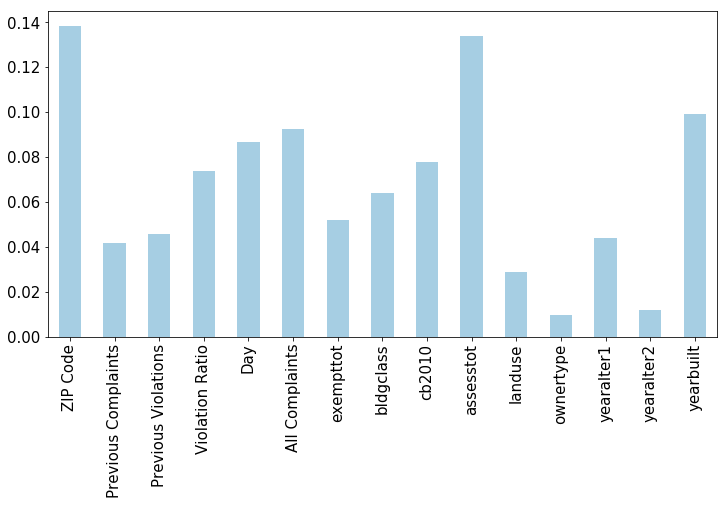

In [814]:
feature_importances.plot(kind='bar', legend=False, colormap='Paired', stacked=True, figsize=(12,6), fontsize=15)

# Metrics

In [815]:
# Playing with n_estimators and max_depth improves metrics

In [816]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.utils.multiclass import unique_labels

### ROC Curve

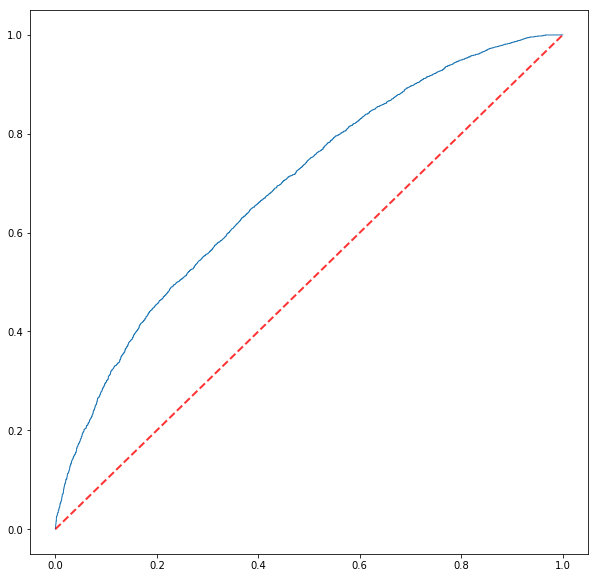

In [817]:
y_predict_probs = clf.predict_proba(X_test)
y_preds = clf.predict(X_test)
# print(clf.classes_)
# print(y_predict_probs)

fpr, tpr, thresholds = roc_curve(y_test, y_predict_probs[:,1])

roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,10))

plt.plot(fpr, tpr, lw=1, alpha=1,
         label='ROC')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

In [818]:
y_preds.sum()

5893

### Priority Score 2!

In [972]:
from statistics import mean

def accuracy_priority_score(scores_by_day):
    
    priorities = pd.DataFrame(list(scores_by_day.values))
    print("Average True positive Accuracy: {}".format(priorities[0].dropna().mean()))
    print("Average True Negative Accuracy: {}".format(priorities[1].dropna().mean()))

def day_priority_score(violations):
#     print(violations)
    number_of_violations = violations.sum()

    true_positive_accuracy = violations[:number_of_violations].sum() / number_of_violations
    true_negative_accuracy = (~violations[number_of_violations:].astype(bool)).sum() / (len(violations) - number_of_violations) 
    
    return [true_positive_accuracy, true_negative_accuracy]
    

In [983]:
#### Random Score
random_by_day = priority_testing_features.groupby('Date Entered').apply(lambda row: day_priority_score(row.sample(frac=1)['Violation']))

print("\nRandom \n -------------------------")
accuracy_priority_score(random_by_day)
####

#### Baseline Score
baseline_by_day = priority_testing_features.groupby('Date Entered').apply(lambda row: day_priority_score(row.sort_values(by='Response Time')['Violation']))

print("\nBaseline \n -------------------------")
accuracy_priority_score(baseline_by_day)
####

#### Model Score
model_by_day = priority_testing_features.groupby('Date Entered').apply(lambda row: day_priority_score(row.sort_values(by='Priority', ascending=False)['Violation']))

print("\nModel\n -------------------------")
accuracy_priority_score(model_by_day)
####

/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]
/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  



Random 
 -------------------------
Average True positive Accuracy: 0.6312621836562182
Average True Negative Accuracy: 0.7386405699162901

Baseline 
 -------------------------
Average True positive Accuracy: 0.6562220027486904
Average True Negative Accuracy: 0.7563725140885634

Model
 -------------------------
Average True positive Accuracy: 0.6896742255651204
Average True Negative Accuracy: 0.7850468233184282


In [899]:
baseline_priority_score = priority_testing_features.groupby('Date Entered').apply(lambda row: jake_score(row.sort_values(by='Response Time')['Violation']))
# print("{} are not nan".format((~baseline_priority_score.isna() * 1).sum() / len(baseline_priority_score)))
# baseline_priority_score = baseline_priority_score.mean()
priorities = pd.DataFrame(list(baseline_priority_score.values))

/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  
/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


In [873]:
model_priority_score = priority_testing_features.groupby('Date Entered').apply(lambda row: jake_score(row.sort_values(by='Priority', ascending=False)['Violation']))
random_priority_score = priority_testing_features.groupby('Date Entered').apply(lambda row: jake_score(row.sample(frac=1)['Violation']))


print("Random priority score {}".format(random_priority_score.mean()))
print("Baseline priority Score: {}".format(baseline_priority_score))
print("Model priority score {}".format(model_priority_score.mean()))
# model_priority_score

/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  
/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


Random priority score 0.9494851423828697
Baseline priority Score: 1.0986567693669966
Model priority score 1.1945945815548087


### Priority Score 1

In [819]:
from statistics import mean

def average_priority_score(violations):
#     print(s)
    priorities = []
#     print(violations)
#     print()
    for i, v in enumerate(violations):
        if v:
            priorities.append(i)
#     print(priorities)
    if priorities == []:
        return None
    return mean(priorities)         

In [820]:
baseline_priority_score = priority_testing_features.groupby('Date Entered').apply(lambda row: average_priority_score(row.sort_values(by='Response Time')['Violation']))
print("{} are not nan".format((~baseline_priority_score.isna() * 1).sum() / len(baseline_priority_score)))
baseline_priority_score = baseline_priority_score.mean()
baseline_priority_score

0.6879049676025918 are not nan


1.415453476403241

In [821]:
priority_testing_features.groupby('Date Entered').apply(lambda row: (row.sort_values(by='Response Time')['Response Time']))

Date Entered       
2016-01-01    8363      60
2016-01-02    10990     18
              14448     34
              5773      46
2016-01-03    5774      26
              14449     33
              13098     45
2016-01-04    16511      2
              3238       3
              16510     24
              15818     31
              15707     44
              12954     46
              16512     61
              13021     71
              16508    127
2016-01-05    16515      1
              13101      7
              13102     21
              7619      22
              8365      23
              16513     32
              16514     32
              4635      34
              4637      34
              14382     34
              13104     42
              8364      58
2016-01-06    14309      3
              13109      6
                      ... 
2019-04-29    13816      0
              16963      0
              16964      0
              16965      0
2019-04-30    5201       0
        

In [822]:
# make predictions for priority set

priority_predictions = clf.predict(priority_testing_X)
priority_predictions_prob = clf.predict_proba(priority_testing_X)

print("Priority Testing balance: {}".format(priority_testing_y.sum() / len(priority_testing_y)))
print("Priority Testing accuracy: {}".format(clf.score(priority_testing_X, priority_testing_y)))
# priority_predictions
print(clf.classes_)
# print(priority_predictions_prob)

priority_testing_features['Priority'] = priority_predictions_prob[:,1]
# print(priority_predictions_prob[:,1])
# priority_testing_features.head()

Priority Testing balance: 0.437984496124031
Priority Testing accuracy: 0.5746124031007752
[0 1]


/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [823]:
# priority_testing_features.groupby('Date Entered').apply(lambda row: (row.sort_values(by='Date Entered', ascending=False)['Date Entered']))

### Compare our model's priority score to a random order and the DOB's ordering

In [824]:
model_priority_score = priority_testing_features.groupby('Date Entered').apply(lambda row: average_priority_score(row.sort_values(by='Priority', ascending=False)['Violation']))
random_priority_score = priority_testing_features.groupby('Date Entered').apply(lambda row: average_priority_score(row.sample(frac=1)['Violation']))


print("Random priority score {}".format(random_priority_score.mean()))
print("Baseline priority Score: {}".format(baseline_priority_score))
print("Model priority score {}".format(model_priority_score.mean()))
# model_priority_score

Random priority score 1.4743742129142443
Baseline priority Score: 1.415453476403241
Model priority score 1.2764353712744607


### Confusion Matrix

[0 1]
Confusion matrix, without normalization
[[2547 1980]
 [1560 3819]]
0.5
[0 1]
Normalized confusion matrix
[[0.56 0.44]
 [0.29 0.71]]
0.5


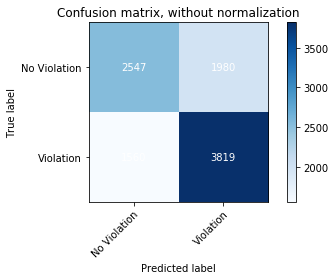

<Figure size 1080x1080 with 0 Axes>

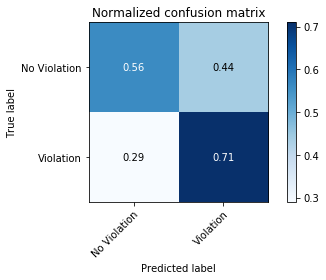

<Figure size 1080x1080 with 0 Axes>

In [787]:
# Code frome: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    print(unique_labels(y_true, y_pred))
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    plt.figure(figsize=(15,15))
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
    thresh = 0.5
    print(thresh)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

class_names = ['No Violation', 'Violation']

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_preds, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_preds, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [560]:
# Most confident predictions
sorted(y_predict_probs[:,1])[::-1]

[0.7635292754253699,
 0.7601688550948889,
 0.7592238344577933,
 0.7590191969277782,
 0.7579911043487263,
 0.7579014166042167,
 0.7574797716795998,
 0.7559900935942095,
 0.7543568874557534,
 0.7518109938178368,
 0.7518035070475964,
 0.7512947320364337,
 0.7506012168975809,
 0.7500864777423332,
 0.7500764727354106,
 0.7499377987726562,
 0.7499106942373135,
 0.7496591088940185,
 0.7491037324892666,
 0.749002492057712,
 0.7488511031401962,
 0.7484099062851124,
 0.7481679091737152,
 0.7446462200044605,
 0.7445673295817302,
 0.7441885404136356,
 0.7440443779027864,
 0.7438875175326347,
 0.7438796823260222,
 0.7438731050311393,
 0.7437529351049702,
 0.7430154910978969,
 0.7429244439646874,
 0.7429137631934676,
 0.7428045894002501,
 0.7422930243719928,
 0.7422011090167345,
 0.742181238691788,
 0.742164151802997,
 0.7417239423970189,
 0.7409016193330402,
 0.7409016193330402,
 0.7407303514146261,
 0.7407178618225948,
 0.7406070737967392,
 0.7405591538514914,
 0.7404756221900946,
 0.7396807793441